# Anomaly Detection (Binary 2D)

Discuss dataset here including shape. Also discuss which data set you specifically chose here.


**Inputs**  


The 14 waveforms (features) reported in the dataset in order are:

- `A+IGBT-I`: Current passing through the IGBT switch of phase A+ in Qa1 ($A$).  
- `A+*IGBT-I`: Current passing through the IGBT switch of phase A+\* in Qa3 ($A$).  
- `B+IGBT-I`: Current passing through the IGBT switch of phase B+ in Qb1 ($A$).  
- `B+*IGBT-I`: Current passing through the IGBT switch of phase B+\* in Qb3 ($A$).  
- `C+IGBT-I`: Current passing through the IGBT switch of phase C+ in Qc1 ($A$).  
- `C+*IGBT-I`: Current passing through the IGBT switch of phase C+\* in Qc3 ($A$).  
- `A-Flux`: Magnetic flux density for phase A in transformer XA ($-$).  
- `B-Flux`: Magnetic flux density for phase B in transformer XB ($-$).  
- `C-Flux`: Magnetic flux density for phase C in transformer XC ($-$).  
- `Mod-V`: Modulator voltage ($V$).  
- `Mod-I`: Modulator current ($A$).  
- `CB-I`: Cap bank current ($-$).  
- `CB-V`: Cap bank voltage ($V$).  
- `DV/DT`: Time derivative change of the Mod\-V voltage ($-$).

**Outputs**
- `Fault`: Faulty wave pulse
- `Normal` Normal wave pulse

**Shaping**
Outputs are 1x3 arrays, with the first element being occurrences, second being timesteps, and third being `Fault` or `Run`

![Image](display.jpg)




**Files and Descriptions**

The files provided in the dataset are:

- `RFQ.npy`: 3D numpy array of the normal and faulty pulses for the RFQ system (shape: (872, 4500, 14)).
- `RFQ_labels.npy`: 2D numpy array of the labels for the RFQ system (shape: (872, 3)).
- `DTL.npy`: 3D numpy array of the normal and faulty pulses for the DTL system (shape: (1077, 4500, 14)).
- `DTL_labels.npy`: 2D numpy array of the labels for the DTL system (shape: (1077, 3)).
- `CCL.npy`: 3D numpy array of the normal and faulty pulses for the CCL system (shape: (2057, 4500, 14)).
- `CCL_labels.npy`: 2D numpy array of the labels for the CCL system (shape: (2057, 3)).
- `SCL.npy`: 3D numpy array of the normal and faulty pulses for the SCL system (shape: (4598, 4500, 14)).
- `SCL_labels.npy`: 2D numpy array of the labels for the SCL system (shape: (4598, 3)).

High Voltage Converter Modulators (HVCM) have frequent failures, making them a major source of down time for the Spallation neutron source. HVCMs are well instrumented to collect large amounts of waveform data including but not limited to modulator current, modulator voltage, magnetic flux, cap bank voltage, cap bank current, and others. These waveform data are collected from all 15 HVCM systems for the application of anomaly detection and failure prediction.

All 15 modulators are grouped into four major subsystems based on their type as follows: 1 modulator as radio-frequency quadrupole (RFQ), 2 modulators as drift-tube linac (DTL), 4 modulators as coupled-cavity linac (CCL), and 8 modulators as super-conducting linac (SCL). A waveform is featured by consecutive pulses, which could be either a normal pulse if the system is healthy, or anomaly pulse if the system is close to failing. These pulses are collected and reported in the dataset of this paper, where the details of the data collection and processing are described in the next section.

The researchers will select the DTL dataset

![Image](data.jpg) fxample.

4598, 3)

In [1]:
import pickle
import sys
import matplotlib.pyplot as plt
sys.path.insert(0, "supporting/anomaly")

from supporting.anomaly.preprocessing import load_anomaly_data, split_sequences
import supporting.anomaly.settings as anomaly_settings
import pyMAISE as mai

2024-07-02 17:24:45.095198: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-02 17:24:45.095230: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-02 17:24:45.096494: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-02 17:24:45.101810: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-02 17:24:45.720659: W tensorflow/compiler/tf2

## pyMAISE Initialization
In the settings file, the researchers initialize pyMAISE as a classification problem and load the DTL data set. GPU is defined and utilized for LSTM, GRU, and CNN-LSTM models.

In [2]:
global_settings = mai.init(
    problem_type=anomaly_settings.problem_type,
    random_state=anomaly_settings.random_state,
    cuda_visible_devices="1",  # Use GPU 1
)

The settings file defines a 70/30 training and testing split. To train the machine learning models the researchers desire roughly a 50/50 split between `Fault` and `Normal`. There were significantly more `Normal` cases, so these `normal` datapoints were removed at random points to preserve the sequential pattern of the time dataset.

![Frequency of positive/negative values in anomaly detection data.](supporting/anomaly/figs/bc2_frequency.png)

This plot shows the frequency of `Normal` and `Fault` cases with the trimmed positive data.


In [3]:
data = load_anomaly_data(
    global_settings=global_settings,
    stack_series=True,
    multiclass=False,
    test_size=anomaly_settings.test_size,
    non_faulty_frac=anomaly_settings.non_faulty_frac,
    timestep_step=1,
)
xtrain, xtest, ytrain, ytest = split_sequences(
    data=data[:-1],
    input_steps=10,
    output_steps=1,
    output_position=0,
)

xtrain shape: (303, 4500, 14)
xtest shape: (131, 4500, 14)
ytrain shape: (303, 4500, 2)
ytest shape: (131, 4500, 2)


In [4]:
xtrain

<xarray.DataArray (samples: 1363491, time steps: 10, features: 14)>
array([[[0.60082346, 0.61231536, 0.80324602, ..., 0.50068486,
         0.95672202, 0.48514414],
        [0.6017403 , 0.61263543, 0.80365735, ..., 0.50068486,
         0.9566316 , 0.48514414],
        [0.60143465, 0.61231536, 0.80406862, ..., 0.50114417,
         0.9566316 , 0.48758441],
        ...,
        [0.57881939, 0.61359566, 0.80406862, ..., 0.49976614,
         0.95685768, 0.483924  ],
        [0.56231725, 0.61551613, 0.80653638, ..., 0.49976614,
         0.95654106, 0.48270416],
        [0.53847891, 0.61135513, 0.80406862, ..., 0.49976614,
         0.95649588, 0.48270398]],

       [[0.6017403 , 0.61263543, 0.80365735, ..., 0.50068486,
         0.9566316 , 0.48514414],
        [0.60143465, 0.61231536, 0.80406862, ..., 0.50114417,
         0.9566316 , 0.48758441],
        [0.60235149, 0.61263543, 0.80324602, ..., 0.50114417,
         0.95654106, 0.48636383],
...
        [0.6054076 , 0.61327559, 0.80324602, ..., 0.49884751,
         0.91376054, 0.52907044],
        [0.60571331, 0.61423582, 0.8044799 , ..., 0.49976614,
         0.91398662, 0.52662671],
        [0.6054076 , 0.61487609, 0.80406862, ..., 0.49884751,
         0.91448408, 0.52663171]],

       [[0.60663009, 0.61391574, 0.80365735, ..., 0.49976614,
         0.91448408, 0.53150922],
        [0.60601896, 0.61519599, 0.8053025 , ..., 0.50068486,
         0.9145745 , 0.53150922],
        [0.60601896, 0.61423582, 0.80406862, ..., 0.49884751,
         0.9135344 , 0.52906549],
        ...,
        [0.60571331, 0.61423582, 0.8044799 , ..., 0.49976614,
         0.91398662, 0.52662671],
        [0.6054076 , 0.61487609, 0.80406862, ..., 0.49884751,
         0.91448408, 0.52663171],
        [0.60510194, 0.61455595, 0.80406862, ..., 0.49701005,
         0.91461974, 0.52296853]]])
Coordinates:
  * samples     (samples) int64 0 1 2 3 4 ... 1363487 1363488 1363489 1363490
  * time steps  (time steps) int64 0 1 2 3 4 5 6 7 8 9
  * features    (features) object 'A+IGBT-I: current' ... 'DV/DT'

In [5]:
ytrain

<xarray.DataArray (samples: 1363491, features: 2)>
array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]])
Coordinates:
  * samples   (samples) int64 0 1 2 3 4 ... 1363487 1363488 1363489 1363490
  * features  (features) object 'Class_Fault' 'Class_Run'

## Model Initialization and Hyperparameter Tuning

The researchers will compare the performance of 3 machine learning (ML) models:

- Long short-term memory: `LSTM`,
- Gated recurrent unit: `GRU`,
- Convolusional neural network: `CNN-LSTM`

Both `LSTM` and `GRU` utilize input, output, and dense input/output layers, in order. The `CNN-LSTM` uses a convolusion, max pooling, and LSTM layers in order. The researchers define the hyperparameter search objective as accuracy, utilizing Bayesian optimization and 50 trials. This is used to find the best hyperparameters that maximize accuracy. The results are saved using `pickle` and imported to Jupyter.

![Convergence of Bayesian optimizer to best hyperparameter configuration.](supporting/anomaly/figs/bc2_convergence.png)

The search could not produce an LSTM/GRU configuration with performance better than ~0.60.

In [6]:
%%time
with open("supporting/anomaly/configs/binary_case_2.pkl", "rb") as f:
    configs = pickle.load(f)

CPU times: user 58.2 ms, sys: 362 ms, total: 420 ms
Wall time: 435 ms


2024-07-02 17:24:47.447865: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-02 17:24:47.477922: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-02 17:24:47.478180: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

## Model Postprocessing

With the models tuned and the top hyperparameters saved, we can now pass these models to the `pyMAISE.PostProcessor` for model comparison and analysis. We will increase the `LSTM`, `GRU`, and `CNN-LSTM` models epochs for better performance.

In [7]:
%%time
postprocessor = mai.PostProcessor(
    data=(xtrain, xtest, ytrain, ytest),
    model_configs=[configs],
    new_model_settings={
        "LSTM": {"fitting_params": {"epochs": 10}},
        "GRU": {"fitting_params": {"epochs": 10}},
        "CNN-LSTM": {"fitting_params": {"epochs": 10}},
    },
)

2024-07-02 17:24:51.162589: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2024-07-02 17:24:51.671601: I external/local_xla/xla/service/service.cc:168] XLA service 0x7ed3f0763680 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-07-02 17:24:51.671627: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2024-07-02 17:24:51.677164: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1719955491.751409   64154 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


CPU times: user 18h 31s, sys: 1h 42min 32s, total: 19h 43min 4s
Wall time: 10h 51min 31s


To compare the performance of these models, we will compute four metrics for both the training and testing data: 
- `Accuracy` = $\frac{\text{Number of Correct Predictions}}{\text{Number of Instances}}$
- `Recall`= $\frac{\text{True Positives}}{\text{True Positives}+\text{False Negatives}}$
- `Precision` = $\frac{\text{True Positives}}{\text{True Positives}+\text{False Positives}}$
- `F1`= $\frac{2*\text{Precision}*\text{Recall}}{\text{Precision}+\text{Recall}}$

In [8]:
postprocessor.metrics()

,Model Types,Parameter Configurations,Train Accuracy,Train Recall,Train Precision,Train F1,Test Accuracy,Test Recall,Test Precision,Test F1
7,GRU,"{'GRU_input_0_units': 84, 'GRU_num_layers': 0,...",0.844081,0.775208,0.896692,0.801602,0.800759,0.766864,0.850631,0.775681
12,CNN-LSTM,"{'Conv1D_input_0_filters': 125, 'Conv1D_input_...",0.848545,0.782312,0.897398,0.808668,0.799413,0.767018,0.842239,0.775719
6,GRU,"{'GRU_input_0_units': 89, 'GRU_num_layers': 0,...",0.832369,0.768826,0.861457,0.791273,0.798182,0.767579,0.833640,0.776116
11,CNN-LSTM,"{'Conv1D_input_0_filters': 89, 'Conv1D_input_0...",0.838057,0.765398,0.896728,0.791708,0.794377,0.757858,0.853703,0.765805
0,LSTM,"{'LSTM_input_0_units': 84, 'LSTM_num_layers': ...",0.838154,0.766411,0.893973,0.792486,0.793690,0.757175,0.852620,0.765048
9,GRU,"{'GRU_input_0_units': 114, 'GRU_num_layers': 0...",0.836688,0.767485,0.883511,0.792529,0.793191,0.758828,0.841611,0.766872
5,GRU,"{'GRU_input_0_units': 160, 'GRU_num_layers': 0...",0.837145,0.764262,0.895623,0.790444,0.793088,0.755891,0.855245,0.763597
14,CNN-LSTM,"{'Conv1D_input_0_filters': 50, 'Conv1D_input_0...",0.836952,0.764376,0.894240,0.790435,0.793062,0.756725,0.850752,0.764554
10,CNN-LSTM,"{'Conv1D_input_0_filters': 86, 'Conv1D_input_0...",0.841976,0.773711,0.890866,0.799491,0.791415,0.757251,0.838132,0.765136
3,LSTM,"{'LSTM_input_0_units': 114, 'LSTM_num_layers':...",0.832402,0.766711,0.866456,0.789867,0.788923,0.756540,0.827333,0.764290


Based on the performance above, the LSTM model is the top performing model. The top 3 models are LSTM, and their corresponding accuracy scores are in the low 60\% and high 50\% respectively. GRU struggled to produce a higher accuracy than 57%, with an average being around 54%. 

Next, the best-performing model hyperparameters are shown.

In [9]:
for model in ["LSTM", "GRU", "CNN-LSTM"]:
    for key, value in postprocessor.get_params(model_type=model).to_dict().items():
        print(f"{key}: {value[0]}")
    print()

Model Types: LSTM
LSTM_input_0_units: 84
LSTM_num_layers: 0
LSTM_output_0_units: 101
LSTM_output_0_activation: tanh
Dense_num_layers: 2
Adam_learning_rate: 0.0003604165151565227
Adam_clipnorm: 0.9071942838879863
Adam_clipvalue: 0.41857106212656064
LSTM_0_units: 151
LSTM_0_activation: sigmoid
Dense_0_units: 153
batch_size: 64
Dense_1_units: 60
Dense_2_units: 138
LSTM_1_units: 144
LSTM_1_activation: tanh
LSTM_2_units: 70
LSTM_2_activation: sigmoid
LSTM_3_units: 81
LSTM_3_activation: tanh
Dense_3_units: 194

Model Types: GRU
GRU_input_0_units: 84
GRU_num_layers: 0
GRU_output_0_units: 101
GRU_output_0_activation: tanh
Dense_num_layers: 2
Adam_learning_rate: 0.0003604165151565227
Adam_clipnorm: 0.9071942838879863
Adam_clipvalue: 0.41857106212656064
GRU_0_units: 151
GRU_0_activation: sigmoid
Dense_0_units: 153
batch_size: 64
Dense_1_units: 60
Dense_2_units: 138
GRU_1_units: 144
GRU_1_activation: tanh
GRU_2_units: 70
GRU_2_activation: sigmoid
GRU_3_units: 81
GRU_3_activation: tanh
Dense_3_uni

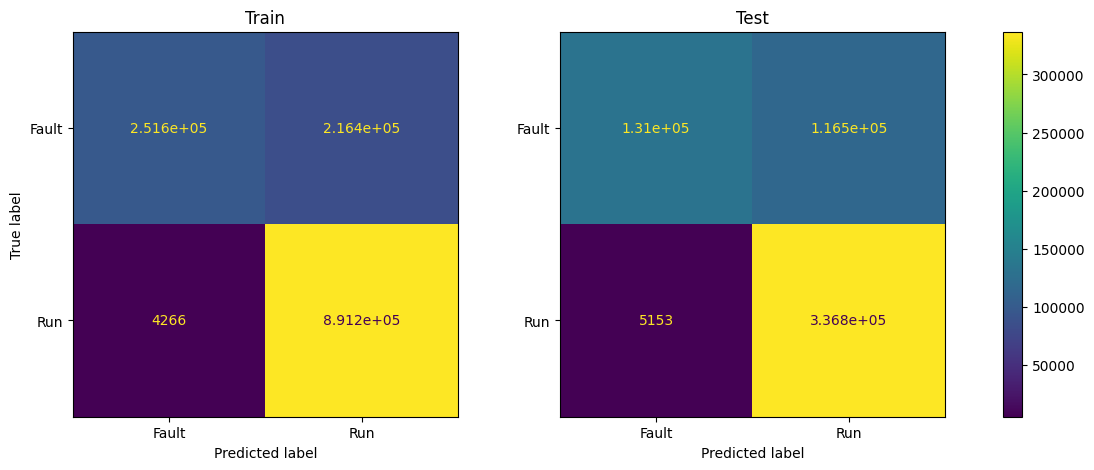

In [10]:
postprocessor.confusion_matrix(model_type="LSTM", figsize=(15, 5))
plt.show()

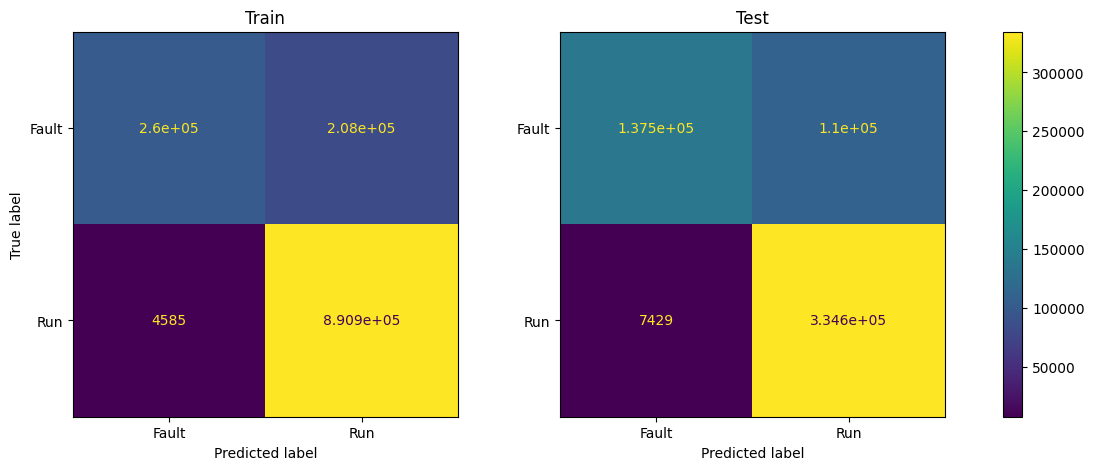

In [11]:
postprocessor.confusion_matrix(model_type="GRU", figsize=(15, 5))
plt.show()

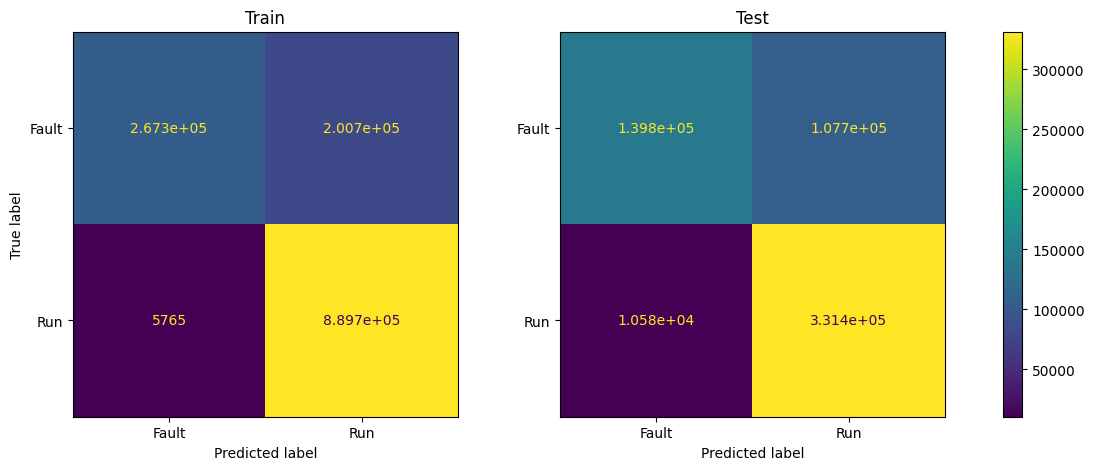

In [12]:
postprocessor.confusion_matrix(model_type="CNN-LSTM", figsize=(15, 5))
plt.show()

Discuss confusion matrix results.

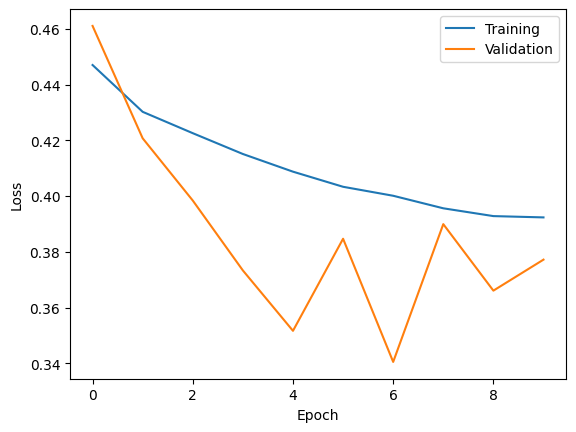

In [13]:
postprocessor.nn_learning_plot(model_type="LSTM")
plt.show()

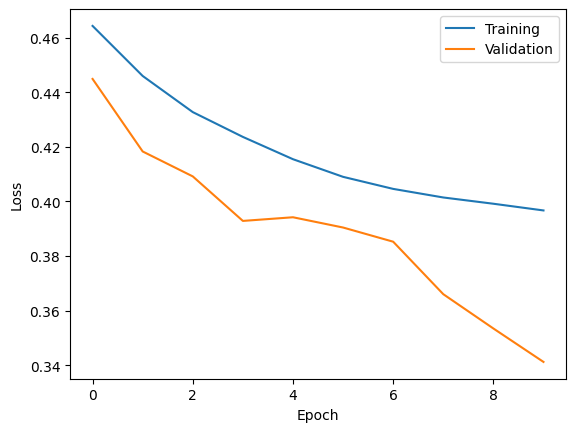

In [14]:
postprocessor.nn_learning_plot(model_type="GRU")
plt.show()

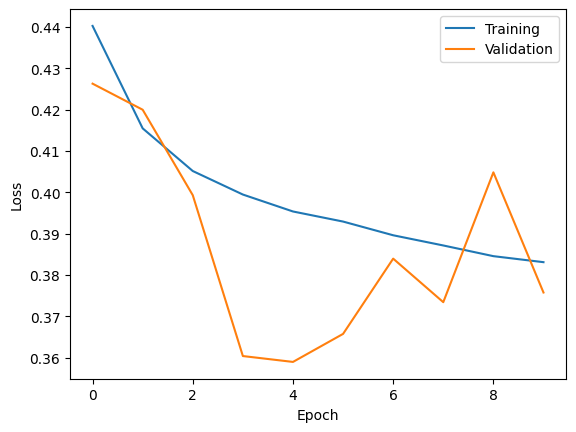

In [15]:
postprocessor.nn_learning_plot(model_type="CNN-LSTM")
plt.show()

Discuss neural network learning curves.

![Image](supporting/anomaly/figs/pyMAISElogo.png)